# CSC 477 Final Project by Zach Sturgill

Version with plotly graphs:https://nbviewer.jupyter.org/github/zachsturg/UFO-Data-Analysis/blob/master/UFO_DataMining.ipynb
The following is a look into the 'UFO Sightings' data set found at: https://www.kaggle.com/NUFORC/ufo-sightings

To keep the interactive graphs and maps, I needed to use a different slide editor. This link should bring you to my presentation: https://plot.ly/~zachsturg/137/_477-presentation/#/

The data set contains the date/time, city/state/country, duration, UFO shape, comments, and latitude and longitude of the sighting. I quickly began experimenting with the geospatial data using the library Geopandas. This was useful, but I soon found another library/service called Plotly which allowed me to create the more interactive and visually appealing maps and graphs. Plotly offers the ability to create graphs in code which are automatically uploaded to their site. From the site it is simple to customize the style and settings of the graphs; this is something I took advantage of in fine-tuning the styling. The creation of these charts was the main challenge of this project: learning how to apply rather complex libraries, and then working with the Plotly website and the necessary Spectacle editor for the presentation. In addition, I also used a module called Word Cloud to easily sort through the comments and output and interesting display based on the frequency of words. Lastly, I attempted to make predictions of the UFO shape based on the time duration. Without much to go on as far as features and a fairly large number of class with large variations in class populations, I did not have high hopes or this. I normalized the data and ran cross validation on Random Forests, Decision Trees, and KNN’s, with varying parameters. Accuracies for all models were around 20% which is disappointing but expected. I also attempted using latitude and longitude as features, but this gave worst results. Throughout the following I will further explain my methods and reasoning. We shall begin with a few imports.

In order to run the code, you must have word cloud, plotly and geopandas installed. They require other installations. Plotly can be run in online or offline mode. I left the imports for offline if you would like to try that; I did have issues with atleast one graph not working correctly in offline. Otherwise, run it as is, I left my login username and API code at the bottom, perhaps that will work for you if you attempt online.

In [1]:
import pandas as pd
import numpy as np
import geopandas
import shapely
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from PIL import Image
from os import path
import os
import re

#import plotly.offline as py
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)

import ipywidgets as widgets
import shapefile
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
sns.set()

# Word Cloud Source:https://github.com/amueller/word_cloud
from wordcloud import WordCloud


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

plotly.tools.set_credentials_file(username='zachsturg', api_key='FcXkVvffXpK4hiIcCDSs')

# The initial dataframe
Here I bring in the full data set. I drop a row that contains a faulty value and rename longitude to remove a white space.


In [2]:
ufo_df = pd.read_csv('scrubbed.csv', low_memory=False)
ufo_df = ufo_df.drop([0,43782])
ufo_df = ufo_df.rename(columns={'longitude ':'longitude'})
ufo_df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.5950000,-82.188889


# Plotting latitudes and longitudes on world map

This cell uses Geopandas to plot all 83,000 locations on the world map. The map is drawn from another dataframe containing the shapefile of the world. Then the coordinates are drawn over this map. During my experimentation I found how to make a choropleth map with the worlds GDP. I found this to be a seeminly interesting correlation between a countries wealth and UFO sightings. Perhaps linked to culture or technology. Next I looked at world population to visualize a correlation, which there is not an obvious trend, but of course there are other factors involved. 

# GDP with Sightings Overlay

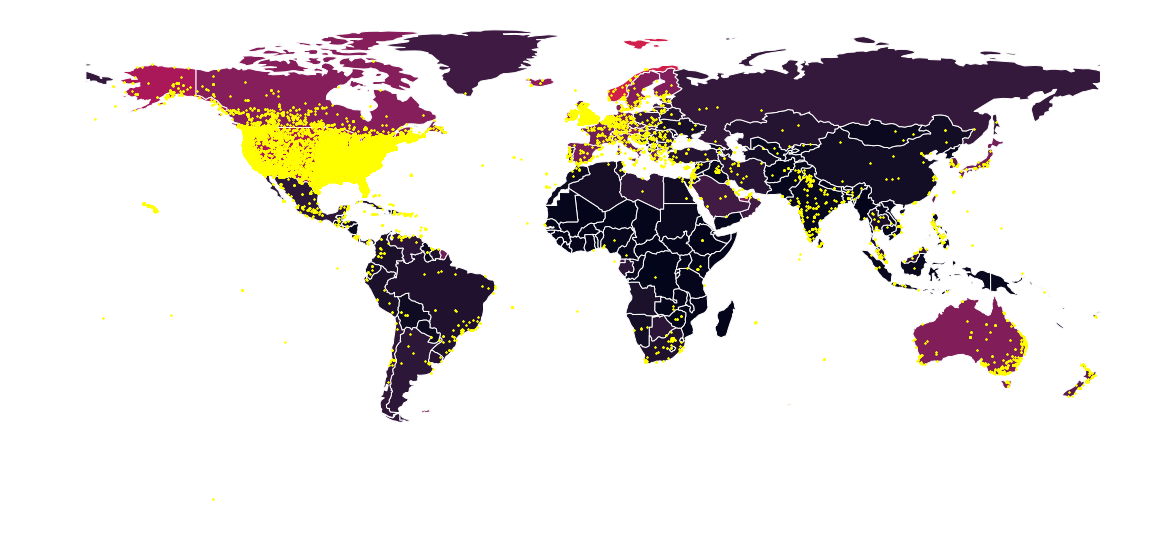

In [3]:
# Create a new DF with just latitude and longitude columns
latLong = ufo_df.loc[:, 'latitude':]

# Latitude column was 'object' type, converted to float 
latLong['latitude'] = latLong['latitude'].astype('float64')

# Prepare coordinates and plot with geopandas
latLong['Coords'] = list(zip(latLong['longitude'], latLong['latitude']))
latLong['Coords'] = latLong['Coords'].apply(Point)
gdf = geopandas.GeoDataFrame(latLong.loc[:,'Coords'], geometry='Coords')

# world is a dataframe containing the information for both GDP and population
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est
ax = world.plot(column='gdp_per_cap', figsize=(20, 10));
gdf.plot(ax=ax, marker='*', color='yellow', markersize=3)
plt.axis('off')
print()

# Population with Sightings Overlay

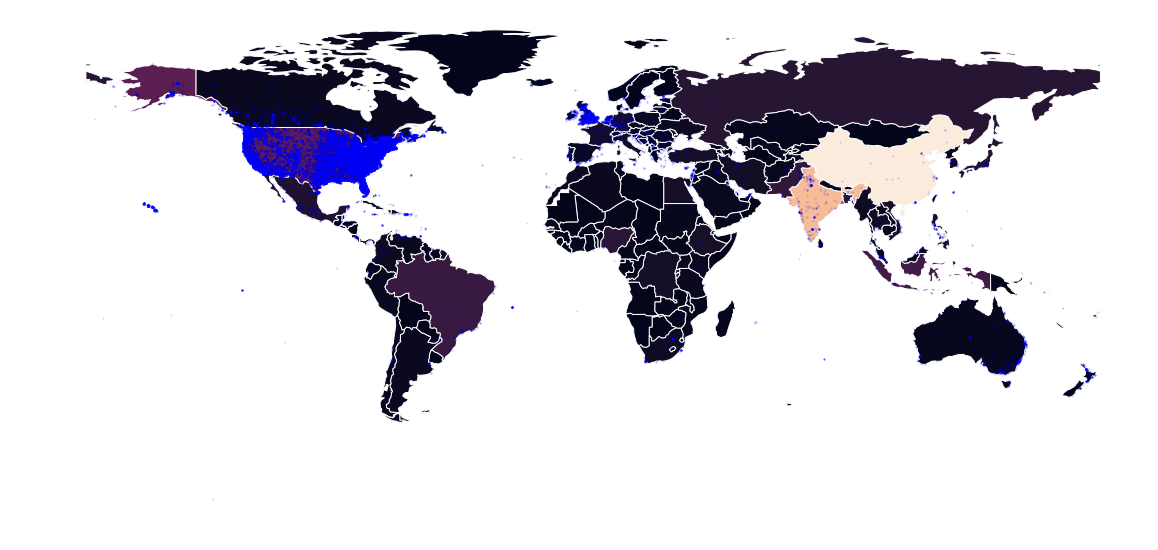

In [4]:
# Create a new DF with just latitude and longitude columns
latLong = ufo_df.loc[:, 'latitude':]

# Latitude column was 'object' type, converted to float 
latLong['latitude'] = latLong['latitude'].astype('float64')

# Prepare coordinates and plot with geopandas
latLong['Coords'] = list(zip(latLong['longitude'], latLong['latitude']))
latLong['Coords'] = latLong['Coords'].apply(Point)
gdf = geopandas.GeoDataFrame(latLong.loc[:,'Coords'], geometry='Coords')
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]
#world['pop_est'] = world.gdp_md_est / world.pop_est
ax = world.plot(column='pop_est', figsize=(20, 10));
gdf.plot(ax=ax, marker='*', color='blue', markersize=3, alpha=.1)
plt.axis('off')
print()

# Getting per State information
I decided to focus on the USA. Since this is a global dataset, some states were either not US states or NaN. I created a list of all US states and removed any row from the dataset that did not contain a state found in the list. I then used a plotly bar graph to visualize this data. These are interesting figures but don't tell any full story. Population and population denstity play a large role in the sightings.

In [5]:
na_only = pd.DataFrame(ufo_df['state'])
na_only['state'] = na_only['state'].str.upper()
na_counts = na_only['state'].value_counts()
states = np.asarray(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
                        'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
                        'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
                        'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
                        'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])


# Drop any 'States' that are not in the United States
na_counts.drop(na_counts[~na_counts.index.isin(states)].index, inplace=True)

data = [go.Bar(
            x=na_counts.index,
            y=na_counts
    )]
layout = go.Layout(title='UFO Sightings per State',
                  xaxis=go.layout.XAxis(
                  title=go.layout.xaxis.Title(
                  text='State')
            ),
                  yaxis=go.layout.YAxis(
                  title=go.layout.yaxis.Title(
                  text='Number of Sightings')
                  )
            )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Per-State')

C:\Users\ZachSturgill\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



# Sightings per State Choropleth
This next cell is basically the same information as the last, but displayed as a choropleth map of the US. I found this to be more visually appealing and equally informative. The used to create this is both the number of sightings per state, and the index of those, the states themselves.

In [6]:
data = [dict(
        type = 'choropleth',
        locations = na_counts.index,
        locationmode = 'USA-states',
        z = na_counts,
        marker = dict(
            line = dict(
                color = 'rgb(255, 255, 255)',
                width = 1)
            )
        )]
layout = dict(
         title = 'Number of Sightings by State',
         geo = dict(
             scope = 'usa',
             countrycolor = 'rgb(255, 255, 255)')
        )
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='PerState Sightings')
             

C:\Users\ZachSturgill\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



# Sightings per 1000 Square Miles

Here I manually went through and found the area of each state, and added that to a dataframe containing the sightings per state and states as an index. I made a third column by dividing sightings per state by state area and then multiplying by 1000. This was used as data to create the choropleth map. The high density of sightings in the New England area is perhaps the most interesting find in this project, and can be explained by the high population density of these states.

In [7]:
state_area = np.asarray([103642, 66456, 53625, 261232, 47126, 113594, 
                         55519, 44743, 40861, 56539, 48618,95988, 
                         68742, 7354, 103642, 39490, 35826, 7800,
                         57513, 54157, 41235,79627, 30061, 4842,
                         39486, 9707,109781, 121298, 68595, 82170,
                         55857, 50645, 52035, 81759, 30843, 43204,
                         82643, 8953, 145546, 24038, 46923, 76824, 
                         570641, 6423, 9217, 1034, 97093, 75811, 
                         1949, 69001])
# Add state areas to DF
na_df = pd.DataFrame(na_counts)
na_df['area'] = state_area

data = [dict(
        type = 'choropleth',
        locations = na_counts.index,
        locationmode = 'USA-states',
        z = na_df['state'] / na_df['area'] * 1000,
        colorbar = dict(
                title = 'Sightings'),
        marker = dict(
            line = dict(
                color = 'rgb(255, 255, 255)',
                width = 1)
            )
        )]
layout = dict(
         title = 'Sightings per 1000 square miles',
         geo = dict(
             scope = 'usa',
             countrycolor = 'rgb(255, 255, 255)')
        )
        
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='PerArea Sightings')
             

C:\Users\ZachSturgill\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



# Cities with the Most Sightings

Here I display a bar graph containing the cities with the most sightings. I only include cities where sightings have been greater than 150 in order to limit the number of cities. Larger cities are at the top showing again a correlation with population. It is interesting that so many sightings happen in locations with high light polution, and I'm sure air traffic.

In [8]:
citiesDf = ufo_df['city'].value_counts()
citiesDf = pd.DataFrame(citiesDf)

data = [go.Bar(
            x=citiesDf.loc[citiesDf['city'] > 150].index,
            y=citiesDf.loc[citiesDf['city'] > 150]
    )]
layout = go.Layout(title='UFO Sightings per City',
                  xaxis=go.layout.XAxis(
                  title=go.layout.xaxis.Title(
                  text='Cities')
                  ),
                  yaxis=go.layout.YAxis(
                  title=go.layout.yaxis.Title(
                  text='Number of Sightings')
                  )
            )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

C:\Users\ZachSturgill\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



# Shape data

In the next to cells I look at the number of sightings per particular shape. I include all shapes in the following bar graph, but remove the shapes with a very few examples for the pie chart in order to remove clutter. This data is vague in that there is a lack of detail. ‘Light’ for instance, as the most frequently observed UFO shape. A believer might imagine a floating ball of light, while others image a potential meteor sighting. The flying saucer is certainly the most popular depiction of a UFO in pop culture, the fact that flying saucer, or what is called disk, is fourth is interesting as well; perhaps it indicates a lack of correlation between sightings and media.

In [9]:
data = [go.Bar(
            x=ufo_df['shape'].unique(),
            y=ufo_df['shape'].astype(str).value_counts()
    )]
layout = go.Layout(title='Distribution of UFO Shapes',
                  xaxis=go.layout.XAxis(
                  title=go.layout.xaxis.Title(
                  text='Shapes')
            ),
                  yaxis=go.layout.YAxis(
                  title=go.layout.yaxis.Title(
                  text='Number of Sightings')
                  )
            )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

C:\Users\ZachSturgill\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [10]:
lesser_shapes = ['delta', 'pyramid', 'round', 'crescent', 'flare', 'hexagon', 'dome', 'changed', 'nan']
shapes_df = ufo_df[~ufo_df['shape'].isin(lesser_shapes)]
labels = list(shapes_df['shape'].unique())
values = list(shapes_df['shape'].astype(str).value_counts())
data = [go.Pie(
            labels = labels,
            values = values,
            title = 'Shapes',
    )]

py.iplot(data, filename='basic-pie')

C:\Users\ZachSturgill\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



# Time Data
Next, I worked on plotting a timeline for the sightings per year. I manipulated the datatime values into just years, and then plotted them versus the sightings per year. There are many factors which could have influenced this data. It begins in 1906, and I'd imagine the UFO recording website wasn't up and running then. So there very well could be data during these times that was never recorded. Plus, without the ease of communication that we have today, it would have been more difficult to collect this data. Today, however, simply get on your phone and go to the NUFORC website. There may also be an association with pop culture. We see the begining of the modern trend occuring  around the same time as the X-Files becomes popular, 1993. Then a very large leap leading up to the 2012 end of the world scare.

In [11]:
ufo_df['datetime'] = pd.to_datetime(ufo_df['datetime'], errors = 'coerce')
years = ufo_df['datetime'].dt.year.value_counts()
years = years.sort_index()
data = [go.Scatter(
    x = years.index.astype('int64'),
    y = years.values
)]
layout = go.Layout(title='UFO Sightings from 1906-2013',
                  xaxis=go.layout.XAxis(
                  title=go.layout.xaxis.Title(
                  text='Years')
            ),
                  yaxis=go.layout.YAxis(
                  title=go.layout.yaxis.Title(
                  text='Number of Sightings')
                  )
            )

fig = go.Figure(data=data, layout=layout)


py.iplot(fig, filename='time-series-simple')

C:\Users\ZachSturgill\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



# Word Cloud
Here I take the comments and join them all together into one long string. The the word cloud module takes this string and outputs this image with the most frequently used words being the most prevelant. I thought it would be fun to use the masking feature to make the output the shape of an alien head.

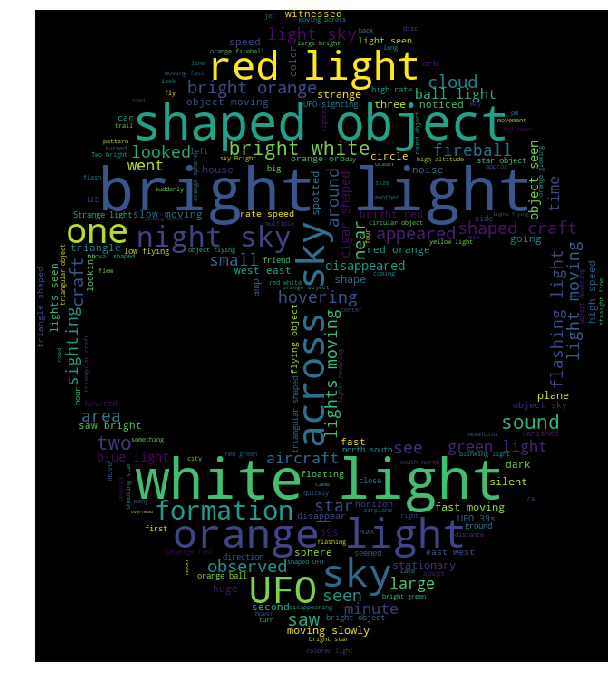

In [12]:
words = ufo_df['comments'].dropna()
words = " ".join(words)

# Using regex to remove some strings that are notes from the National UFO recording center
words = re.sub('NUFORC Note', '', words)
words = re.sub('quot', '', words)

# This line is taken right from the documentation
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Assigning the 'Alien' mask
alien = np.array(Image.open(path.join(d,'alien-1296189_960_720.png')))
plt.subplots(figsize=(28,12))
wordcloud = WordCloud(mask=alien, background_color='black', width=2000, height=1000).generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('graph.png')
plt.show()

# Preparing data for ML models
First, I make a dataframe containing the duration and shapes. Next, I remove the rows containing shapes that are seen very rarely (some only once, and the most 7 times). I also remove three rows based on durations that were strings; it was unclear what the actual data should be. The models performed poorly, as expected, although I had hope. I believe it is caused by a lack of features, and the one feature I used varies a lot. All this while trying to classify 18 different classes. Or maybe the randomness would continue in other features.

In [12]:
lesser_shapes = ['delta', 'pyramid', 'round', 'crescent', 'flare', 'hexagon', 'dome', 'changed', 'nan']
learn_df = pd.DataFrame(ufo_df['duration (seconds)'])
learn_df = learn_df.join(ufo_df['shape']).astype(str)
#Remove some unwanted string values from duration (seconds) column
learn_df = learn_df.drop([27822])
learn_df = learn_df.drop([35692])
learn_df = learn_df.drop([58591])
learn_df = learn_df.dropna()
# Remove the classes that contain only a small number of UFO's
learn_df = learn_df[~learn_df['shape'].isin(lesser_shapes)]
learn_df

,duration (seconds),shape
1,7200,light
2,20,circle
3,20,circle
4,900,light
5,300,sphere
6,180,circle
7,1200,disk
8,180,disk
9,120,disk
10,300,circle


In [13]:
X = np.array(learn_df['duration (seconds)'].astype(float))
X = X.reshape(-1, 1)
#X = learn_df['duration (seconds)'].astype(float)
y = learn_df['shape'].astype(str)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, random_state=0, test_size = 0.2)

# Random Forest
I ran the random forest algorithm with cross validation for a range of n_esitmators from 1-100. All models came out with a similiar accuracy of 20%-21%.

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(n_estimators = 10, random_state = 0)
forest_model.fit(X_train, y_train)
y_pred = forest_model.predict(X_test)

scores = cross_val_score(estimator = forest_model,
                         X = X,
                         y = y,
                         cv = 10)

print('CV accuracy scores for random forest model: ', scores)
print('Mean CV accuracy score: ', np.mean(scores))
print('95% confidence interval for CV accuracy score: ({}, {})'.format(
    np.mean(scores) - 2 * np.std(scores),
    np.mean(scores) + 2 * np.std(scores)))

CV accuracy scores for random forest model:  [0.21052632 0.20912451 0.20971443 0.209157   0.21135204 0.21025772
 0.20903522 0.20875894 0.20973304 0.20902006]
Mean CV accuracy score:  0.20966792706120635
95% confidence interval for CV accuracy score: (0.20810204128524604, 0.21123381283716666)


# Desision Tree
Again I experimented with different depths, but the same outcome of around 20% accuracy.

In [15]:
tree_clf = DecisionTreeClassifier(criterion='entropy', max_depth=2)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)

scores = cross_val_score(estimator = tree_clf,
                         X = X,
                         y = y,
                         cv = 10)

print('CV accuracy scores for decision tree model: ', scores)
print('Mean CV accuracy score: ', np.mean(scores))
print('95% confidence interval for CV accuracy score: ({}, {})'.format(
    np.mean(scores) - 2 * np.std(scores),
    np.mean(scores) + 2 * np.std(scores)))

CV accuracy scores for decision tree model:  [0.2111635  0.2111635  0.21124426 0.21132509 0.21135204 0.21127839
 0.21133231 0.21144025 0.21152127 0.21157532]
Mean CV accuracy score:  0.21133959221770304
95% confidence interval for CV accuracy score: (0.21107579670531518, 0.2116033877300909)


# KNN
Same results of 20% accuracy with a bit more variance

In [16]:
knn = KNeighborsClassifier(n_neighbors=100, p=2, metric='euclidean')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn.score(X_test, y_test)
scores = cross_val_score(estimator = knn,
                         X = X,
                         y = y,
                         cv = 10)

print('CV accuracy scores KNN model: ', scores)
print('Mean CV accuracy score: ', np.mean(scores))
print('95% confidence interval for CV accuracy score: ({}, {})'.format(
    np.mean(scores) - 2 * np.std(scores),
    np.mean(scores) + 2 * np.std(scores)))

CV accuracy scores KNN model:  [0.19880209 0.20440933 0.20971443 0.20941206 0.19732143 0.1987752
 0.18415008 0.20914198 0.20411291 0.19701035]
Mean CV accuracy score:  0.20128498614054494
95% confidence interval for CV accuracy score: (0.1863632265809788, 0.21620674570011106)


# Over accuracy of the three models:

|  Model  | Accuracy |
|---------|----------|
| Random Forest | 21.96%  |
| Decision Tree | 21.13%  |
|  KNN | 20.13% |


# Conclusion
Overall this was an interesting exploration. Do I think this will change the world? Not at all. But I learned a lot about graphing and plotting in a way that I have never done before. I think the data is insightful but vague in the sense that there are so many unknown factors that could have influenced this. I don’t believe that these are all real UFOs, not even close. So, I feel there must be some connections based on our cultures. But it would require further study to delve deeper. Maybe there’s a reason no one really knows if there are UFOs. 